# NFL Baseline
- create target_df (distance in tracking_df is lower than threshold=3)
https://www.kaggle.com/code/stgkrtua/nfl-creatatraindataset-targetdf
- create dataset save frames in target_df
https://www.kaggle.com/code/stgkrtua/nfl-createdataset-saveframes
- check saved images
https://www.kaggle.com/code/stgkrtua/nfl-checkdataset-plotsavedimage

# import libraries

In [66]:
# general
import os
import gc
import pickle
import glob
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import time
import math

import sys
sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
import timm


# deep learning
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import StratifiedKFold

# loss metrics
from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_auc_score

import mlflow
# import wandb
# warningの表示方法の設定
import warnings
warnings.filterwarnings("ignore")

# Set Configurations

In [67]:
CFG = {
        "kaggle" : False,
        "DEBUG" : True,
        # model config
        "model_name" : "tf_efficientnet_b0",
        "inp_channels": 3*2,
        "num_backbone_features" : 20,
        "num_img_feature" : 5,
        "num_track_feature" : 3,
        "pretrained" : True,
        "features" : ['x_position_1', 'y_position_1', 'x_position_2', 'y_position_2', 
                      'speed_1', 'distance_1', 'direction_1', 'orientation_1','acceleration_1', 'sa_1', 
                      'speed_2', 'distance_2', 'direction_2', 'orientation_2', 'acceleration_2', 'sa_2',
                      'speed_diff', 'distance_diff', 'direction_diff', 'orientation_diff','acceleration_diff', 'sa_diff', # diff-feature
                      'players_dis', 'is_ground'],
        "track_features_x_1" : ['x_position_shift-6_1','x_position_shift-5_1', 'x_position_shift-4_1',
                                'x_position_shift-3_1','x_position_shift-2_1', 'x_position_shift-1_1', 
                                'x_position_shift0_1','x_position_shift1_1', 'x_position_shift2_1', 
                                'x_position_shift3_1','x_position_shift4_1', 'x_position_shift5_1'],    
        "track_features_y_1" : ['y_position_shift-6_1','y_position_shift-5_1', 'y_position_shift-4_1',
                                'y_position_shift-3_1','y_position_shift-2_1', 'y_position_shift-1_1',
                                'y_position_shift0_1','y_position_shift1_1', 'y_position_shift2_1',
                                'y_position_shift3_1','y_position_shift4_1', 'y_position_shift5_1'],
        "track_features_x_2" : ['x_position_shift-6_2','x_position_shift-5_2', 'x_position_shift-4_2',
                                'x_position_shift-3_2','x_position_shift-2_2', 'x_position_shift-1_2',
                                'x_position_shift0_2','x_position_shift1_2', 'x_position_shift2_2',
                                'x_position_shift3_2','x_position_shift4_2', 'x_position_shift5_2'],
        "track_features_y_2" : ['y_position_shift-6_2','y_position_shift-5_2', 'y_position_shift-4_2',
                                'y_position_shift-3_2','y_position_shift-2_2', 'y_position_shift-1_2',
                                'y_position_shift0_2','y_position_shift1_2', 'y_position_shift2_2',
                                'y_position_shift3_2','y_position_shift4_2', 'y_position_shift5_2'],
        # learning config
        "n_epoch" : 10,
        "lr" : 1e-4,
        "T_max" : 10,
        "min_lr" : 1e-8,
        "weight_decay" : 1e-6,

        # etc
        "print_freq" : 1000,
        "random_seed" : 21,

        # data config    
        "end_end_img_size" : (224, 224),
        "batch_size" : 32,
        "num_workers" : 8,
        "masksize_helmet_ratio" : 4, # helmetサイズにこの係数をかけたサイズだけ色を残して後は黒塗りする
        "TRAIN_VIDEO_NUM" : 100,
        "VALID_VIDEO_NUM" : 10,
        "sample_num" : -1, 

        "EXP_CATEGORY" : "exps",
        "EXP_NAME" : "exp010_effnetb0_splitbackbone",
}

if CFG["DEBUG"]:
    CFG["EXP_CATEGORY"] = "DEBUG"
    CFG["EXP_NAME"] = "DEBUG"
    CFG["n_epoch"] = 2
    CFG["sample_num"] = 1000
    CFG["batch_size"] = 32
    CFG["num_workers"] = 0

if CFG["kaggle"]:
    CFG["INPUT_DIR"] = "/kaggle/input/"
    CFG["OUTPUT_DIR"] = "/kaggle/working/"
    CFG["TRAIN_HELMET_CSV"] = os.path.join(CFG["INPUT_DIR"], "nfl-player-contact-detection", "train_baseline_helmets.csv")
    CFG["TRAIN_TRACKING_CSV"] = os.path.join(CFG["INPUT_DIR"], "nfl-player-contact-detection", "train_player_tracking.csv")
    CFG["TRAIN_VIDEO_META_CSV"] = os.path.join(CFG["INPUT_DIR"], "nfl-player-contact-detection", "train_video_metadata.csv")
    CFG["TRAIN_LABEL_CSV"] = os.path.join(CFG["INPUT_DIR"], "nfl-player-contact-detection", "train_labels.csv")
    CFG["TARGET_CSV"] = os.path.join(CFG["INPUT_DIR"], "nfl-createdataset-saveframes-shift", "saved_frame_target.csv")
    CFG["TRAIN_E_IMG_DIR"] = os.path.join(CFG["INPUT_DIR"], "nfl-createdataset-saveframes-shift", "train_images")
    CFG["TRAIN_S_IMG_DIR"] = os.path.join(CFG["INPUT_DIR"], "nfl-createdataset-saveframes-shift-sview", "train_images")
    CFG["MODEL_DIR"] = CFG["OUTPUT_DIR"]
else:
    CFG["INPUT_DIR"] = "/workspace/input"
    CFG["OUTPUT_DIR"] = "/workspace/output"
    CFG["TRAIN_HELMET_CSV"] = os.path.join(CFG["INPUT_DIR"], "train_baseline_helmets.csv")
    CFG["TRAIN_TRACKING_CSV"] = os.path.join(CFG["INPUT_DIR"], "train_player_tracking.csv")
    CFG["TRAIN_VIDEO_META_CSV"] = os.path.join(CFG["INPUT_DIR"], "train_video_metadata.csv")
    CFG["TRAIN_LABEL_CSV"] = os.path.join(CFG["INPUT_DIR"], "train_labels.csv")
    CFG["TARGET_CSV"] = os.path.join(CFG["INPUT_DIR"], "target_fillna0_shift_2.csv")
    CFG["TRAIN_E_IMG_DIR"] = os.path.join(CFG["INPUT_DIR"], "train_frames")
    CFG["TRAIN_S_IMG_DIR"] = CFG["TRAIN_E_IMG_DIR"]
    CFG["CONTACT_IMG_DIR"] = os.path.join(CFG["INPUT_DIR"], "contact_images")
    CFG["MODEL_DIR"] = os.path.join(CFG["OUTPUT_DIR"], CFG["EXP_NAME"] ,"model")
    
if not CFG["kaggle"] and not CFG["DEBUG"]:
    os.mkdir(os.path.join(CFG["OUTPUT_DIR"], CFG["EXP_NAME"]))
    os.mkdir(CFG["MODEL_DIR"])


In [68]:
if CFG["kaggle"]:
    os.environ["WANDB_SILENT"] = "true"
    WANDB_CONFIG = {'competition': 'NFL', '_wandb_kernel': 'taro'}
    # Secrets
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("wandb")

    !wandb login $secret_value_0
    #! TODO : logger settings
    wandb.init(project=WANDB_CONFIG["competition"], config=CFG, group=CFG["EXP_CATEGORY"], name=CFG["EXP_NAME"])

else:
    mlflow.set_tracking_uri("/workspace/mlruns")
    experiment = mlflow.get_experiment_by_name(CFG["EXP_CATEGORY"])
    if experiment is None:  # 当該Experiment存在しないとき、新たに作成
        experiment_id = mlflow.create_experiment(name=CFG["EXP_CATEGORY"])
    else: # 当該Experiment存在するとき、IDを取得
        experiment_id = experiment.experiment_id

# Utils

In [69]:
def logging_metrics_epoch(fold, epoch, train_loss_avg, valid_loss_avg, score, threshold, tn_best, fp_best, fn_best, tp_best, auc_score):
    if CFG["kaggle"]:
        wandb.log({"loss avg":{f"train/fold{fold}": train_loss_avg,
                                f"valid/fold{fold}": valid_loss_avg}}, step=epoch)
        wandb.log({"Metircs" : {f"score/fold{fold}":score,
                                f"score threshold/fold{fold}":threshold,
                                f"tn/fold{fold}":tn_best,
                                f"fp/fold{fold}":fp_best,
                                f"fn/fold{fold}":fn_best,
                                f"tp/fold{fold}":tp_best,
                                f"auc/fold{fold}":auc_score,
                               }}, step=epoch)
    else:
        mlflow.log_metric(f"fold{fold} train loss avg", train_loss_avg, step=epoch)
        mlflow.log_metric(f"fold{fold} valid loss avg", valid_loss_avg, step=epoch)
        mlflow.log_metric(f"fold{fold} score", score, step=epoch)
        mlflow.log_metric(f"fold{fold} score threshold", threshold, step=epoch)
        mlflow.log_metric(f"fold{fold} tn", tn_best, step=epoch)
        mlflow.log_metric(f"fold{fold} fp", fp_best, step=epoch)
        mlflow.log_metric(f"fold{fold} fn", fn_best, step=epoch)
        mlflow.log_metric(f"fold{fold} tp", tp_best, step=epoch)
        mlflow.log_metric(f"fold{fold} auc", auc_score, step=epoch)

In [70]:
def seed_everything(seed=CFG["random_seed"]):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed%(2**32-1))
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
    torch.backends.cudnn.benchmark = False
seed_everything()

# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [71]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Load Data

In [121]:
target_df = pd.read_csv(CFG["TARGET_CSV"])
print(len(target_df))
# target_game_plays = target_df["game_play"].unique()[:50]
train_game_plays = target_df["game_play"].unique()[:CFG["TRAIN_VIDEO_NUM"]]
valid_game_plays = target_df["game_play"].unique()[-CFG["VALID_VIDEO_NUM"]:]
target_game_plays = list(set(train_game_plays) | set(valid_game_plays))
CFG["target_game_plays"] = list(target_game_plays)
target_df = target_df[target_df["game_play"].isin(target_game_plays)]

# if CFG["DEBUG"]:
#     target_df = target_df.sample(CFG["sample_num"])
# elif CFG["sample_num"] != -1:
#     target_df = target_df.sample(CFG["sample_num"])

target_df["is_ground"] = (target_df["nfl_player_id_2"] == "G").astype(np.int)

target_df["is_end_helmet"] = 1 - ((target_df["E_width_1"]==0) & (target_df["E_width_2"]==0)).astype(np.int)
target_df["is_side_helmet"] = 1 - ((target_df["S_width_1"]==0) & (target_df["S_width_2"]==0)).astype(np.int)
target_df["is_helmet"] = 1 - ((target_df["E_width_1"]==0) & (target_df["E_width_2"]==0) & (target_df["S_width_1"]==0) & (target_df["S_width_2"]==0)).astype(np.int)

# target_df = target_df[target_df["is_helmet"]==1]

print(len(target_df))
display(target_df["contact"].value_counts())

660553
305164


0    274357
1     30807
Name: contact, dtype: int64

In [119]:
contact_img_list = glob.glob(os.path.join(CFG["CONTACT_IMG_DIR"], "*.jpg"))
print(len(contact_img_list))

1280944


In [122]:
660553*2/1280944

1.0313534393384878

In [107]:
contact_img_id = [img_path.split("/")[-1] for img_path in contact_img_list]
# contact_img_id = [img_id.split("_")[:5] for img_id in contact_img_id]

In [115]:
contact_img_id[0].split("_")

['58168', '003392', '0', '37084', '38567', 'Endzone.jpg']

In [73]:
diff_cols = ['speed', 'distance', 'direction', 'orientation','acceleration', 'sa']

for col in diff_cols:
    target_df[f"{col}_diff"] = abs(target_df[f"{col}_1"] - target_df[f"{col}_2"])

In [74]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.3, 0.3), p=0.5),
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

# Dataset

In [75]:

class NFLDataset(Dataset):
    def __init__(self, df_, transform=None):
        self.target_df = df_
        self.features = df_[CFG["features"]].values
        self.track_features_x_1 = df_[CFG["track_features_x_1"]].values
        self.track_features_y_1 = df_[CFG["track_features_y_1"]].values
        self.track_features_x_2 = df_[CFG["track_features_x_2"]].values
        self.track_features_y_2 = df_[CFG["track_features_y_2"]].values
        self.transform = transform

    def __len__(self):
        return len(self.target_df)

    def __getitem__(self, idx):
        target_info = self.target_df.iloc[idx]
        features = self.features[idx]
        track_x_1 = self.track_features_x_1[idx]
        track_y_1 = self.track_features_y_1[idx]
        track_x_2 = self.track_features_x_2[idx]
        track_y_2 = self.track_features_y_2[idx]
        track_features = np.concatenate([track_x_1[np.newaxis, :],
                                         track_y_1[np.newaxis, :],
                                         track_x_2[np.newaxis, :],
                                         track_y_2[np.newaxis, :]])

        target = target_info.contact
        # read frame image
        game_play = target_info.game_play
        frame = target_info.frame
        contact_id = target_info.contact_id
        
        # Endzone view img
        contact_fileid = f"{contact_id}_Endzone.jpg"
        contact_filename = os.path.join(CFG["CONTACT_IMG_DIR"], contact_fileid)
        end_img = cv2.imread(contact_filename)
        if end_img is None:
            end_img = np.zeros((224, 224, 3))
            end_img = np.transpose(end_img, (2, 0, 1)).astype(np.float)
            end_img = torch.tensor(end_img, dtype=torch.float)
            print(f"end img is None : {contact_fileid}")
        else:
            end_img = cv2.cvtColor(end_img, cv2.COLOR_BGR2RGB)
            if self.transform:
                end_img = self.transform(image=end_img)["image"]
            else:
                end_img = end_img / 255. # convert to 0-1
                end_img = np.transpose(end_img, (2, 0, 1)).astype(np.float32)
            end_img = torch.tensor(end_img, dtype=torch.float)
        
        # Sideline view img 
        contact_fileid = f"{contact_id}_Sideline.jpg"
        contact_filename = os.path.join(CFG["CONTACT_IMG_DIR"], contact_fileid)
        side_img = cv2.imread(contact_filename)
        if side_img is None:
            side_img = np.zeros((224, 224, 3))
            side_img = np.transpose(side_img, (2, 0, 1)).astype(np.float)
            side_img = torch.tensor(side_img, dtype=torch.float)
            print(f"side img is None : {contact_fileid}")
        else:
            side_img = cv2.cvtColor(side_img, cv2.COLOR_BGR2RGB)
            if self.transform:
                side_img = self.transform(image=side_img)["image"]
            else:
                side_img = side_img / 255. # convert to 0-1
                side_img = np.transpose(side_img, (2, 0, 1)).astype(np.float32)
            side_img = torch.tensor(side_img, dtype=torch.float)
        target = torch.tensor(target, dtype=torch.float)
        features = torch.tensor(features, dtype=torch.float)
        track_features = torch.tensor(track_features, dtype=torch.float)
        return end_img, side_img, features, track_features, target

In [97]:
target_df[(target_df["game_play"]=="58168_003392") & (target_df["step"]>=8)]

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,frame,game_frame,game_frame_player_1,...,is_ground,is_end_helmet,is_side_helmet,is_helmet,speed_diff,distance_diff,direction_diff,orientation_diff,acceleration_diff,sa_diff
277,58168_003392_8_38590_47944,58168_003392,2020-09-11 03:01:48.900000+00:00,8,38590,47944,1,346,58168_003392_346,58168_003392_346_38590,...,0,1,1,1,0.21,0.03,31.40,135.32,0.06,0.28
278,58168_003392_8_38590_39947,58168_003392,2020-09-11 03:01:48.900000+00:00,8,38590,39947,0,346,58168_003392_346,58168_003392_346_38590,...,0,1,1,1,0.43,0.04,0.26,8.28,0.59,1.12
279,58168_003392_8_43854_46445,58168_003392,2020-09-11 03:01:48.900000+00:00,8,43854,46445,1,346,58168_003392_346,58168_003392_346_43854,...,0,1,1,1,0.30,0.04,24.85,207.47,2.51,1.70
280,58168_003392_8_41944_45695,58168_003392,2020-09-11 03:01:48.900000+00:00,8,41944,45695,0,346,58168_003392_346,58168_003392_346_41944,...,0,1,1,1,0.02,0.01,16.09,197.42,0.09,0.13
281,58168_003392_8_41944_42565,58168_003392,2020-09-11 03:01:48.900000+00:00,8,41944,42565,1,346,58168_003392_346,58168_003392_346_41944,...,0,1,1,1,0.24,0.03,9.17,165.09,0.78,0.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,58168_003392_68_44869_G,58168_003392,2020-09-11 03:01:54.900000+00:00,68,44869,G,0,705,58168_003392_705,58168_003392_705_44869,...,1,1,1,1,1.41,0.14,47.05,39.46,1.04,0.22
2515,58168_003392_68_39947_G,58168_003392,2020-09-11 03:01:54.900000+00:00,68,39947,G,0,705,58168_003392_705,58168_003392_705_39947,...,1,0,1,1,0.50,0.05,336.05,306.57,0.66,0.66
2516,58168_003392_68_45695_G,58168_003392,2020-09-11 03:01:54.900000+00:00,68,45695,G,0,705,58168_003392_705,58168_003392_705_45695,...,1,1,1,1,0.56,0.04,7.07,66.03,1.98,1.98
2517,58168_003392_68_42565_G,58168_003392,2020-09-11 03:01:54.900000+00:00,68,42565,G,0,705,58168_003392_705,58168_003392_705_42565,...,1,1,1,1,1.38,0.15,346.64,351.09,0.25,0.24


end img torch.Size([4, 3, 224, 224])
side img torch.Size([4, 3, 224, 224])
features shape = torch.Size([4, 24])
track features shape = torch.Size([4, 4, 12])


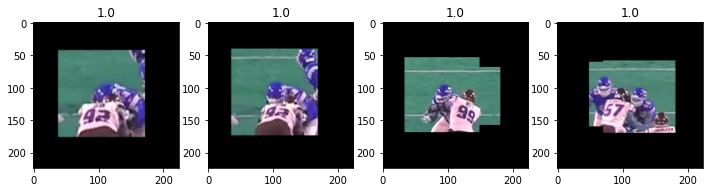

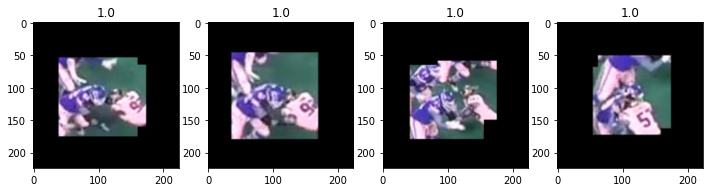

end img torch.Size([4, 3, 224, 224])
side img torch.Size([4, 3, 224, 224])
features shape = torch.Size([4, 24])
track features shape = torch.Size([4, 4, 12])


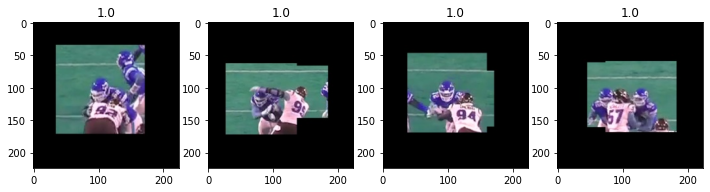

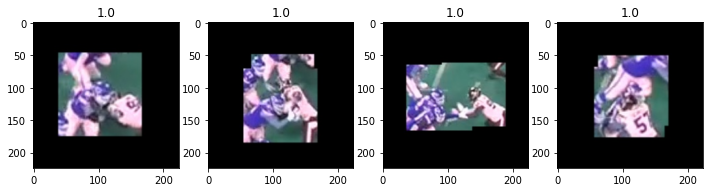

end img is None : 58168_003392_7_38590_47944_Endzone.jpg
side img is None : 58168_003392_7_38590_47944_Sideline.jpg
end img torch.Size([4, 3, 224, 224])
side img torch.Size([4, 3, 224, 224])
features shape = torch.Size([4, 24])
track features shape = torch.Size([4, 4, 12])


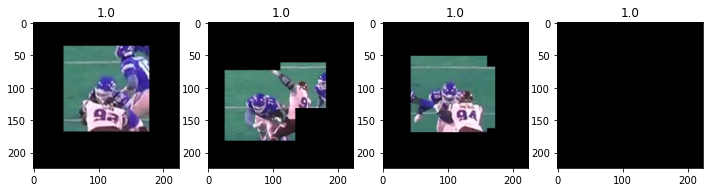

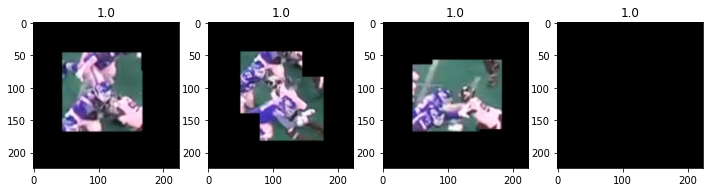

end img torch.Size([4, 3, 224, 224])
side img torch.Size([4, 3, 224, 224])
features shape = torch.Size([4, 24])
track features shape = torch.Size([4, 4, 12])


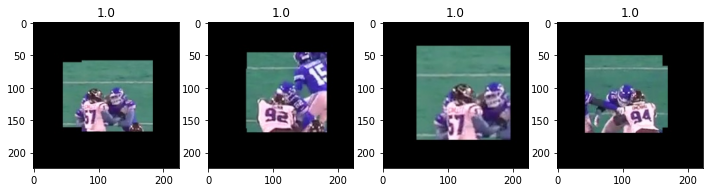

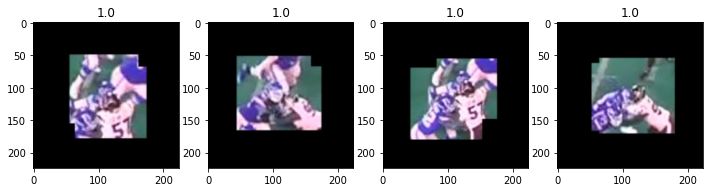

end img is None : 58168_003392_8_38590_47944_Endzone.jpg
side img is None : 58168_003392_8_38590_47944_Sideline.jpg
end img torch.Size([4, 3, 224, 224])
side img torch.Size([4, 3, 224, 224])
features shape = torch.Size([4, 24])
track features shape = torch.Size([4, 4, 12])


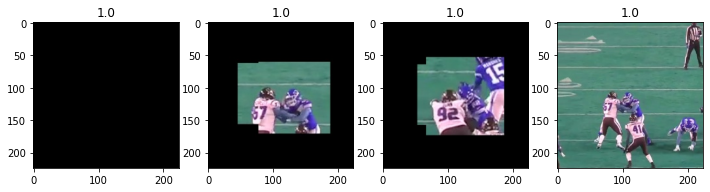

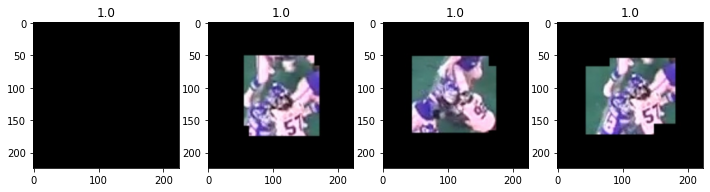

end img is None : 58168_003392_9_38590_47944_Endzone.jpg
side img is None : 58168_003392_9_38590_47944_Sideline.jpg
end img torch.Size([4, 3, 224, 224])
side img torch.Size([4, 3, 224, 224])
features shape = torch.Size([4, 24])
track features shape = torch.Size([4, 4, 12])


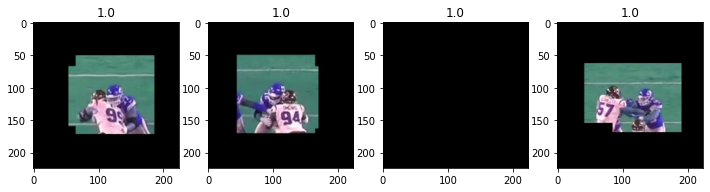

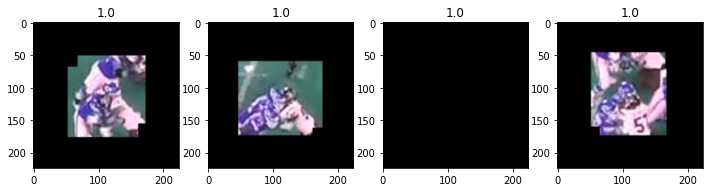

end img torch.Size([4, 3, 224, 224])
side img torch.Size([4, 3, 224, 224])
features shape = torch.Size([4, 24])
track features shape = torch.Size([4, 4, 12])


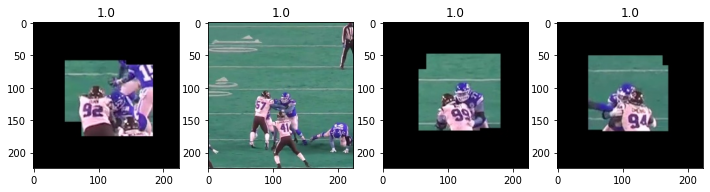

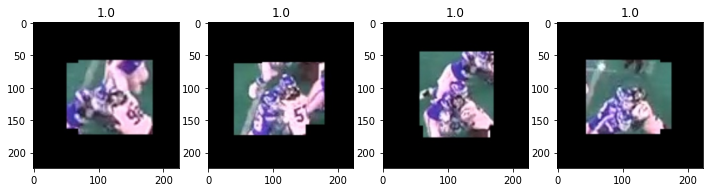

end img is None : 58168_003392_10_38590_47944_Endzone.jpg
side img is None : 58168_003392_10_38590_47944_Sideline.jpg
end img torch.Size([4, 3, 224, 224])
side img torch.Size([4, 3, 224, 224])
features shape = torch.Size([4, 24])
track features shape = torch.Size([4, 4, 12])


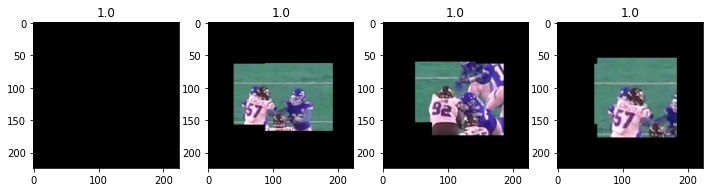

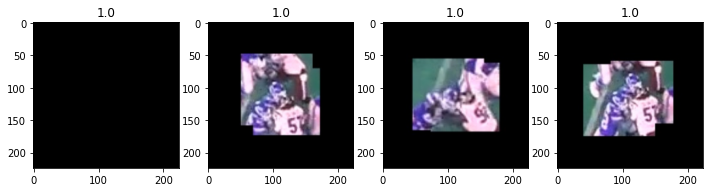

end img is None : 58168_003392_11_38590_47944_Endzone.jpg
side img is None : 58168_003392_11_38590_47944_Sideline.jpg
end img torch.Size([4, 3, 224, 224])
side img torch.Size([4, 3, 224, 224])
features shape = torch.Size([4, 24])
track features shape = torch.Size([4, 4, 12])


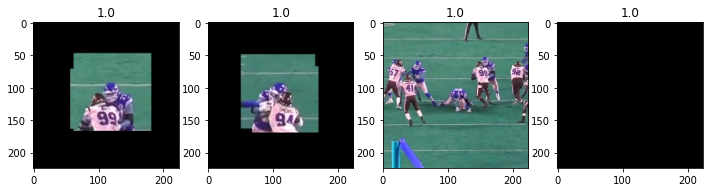

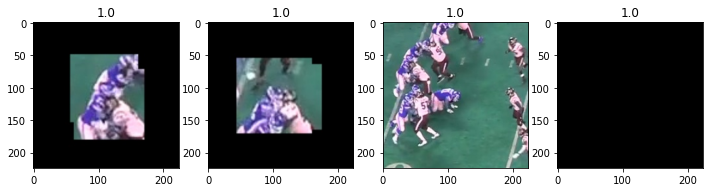

end img torch.Size([4, 3, 224, 224])
side img torch.Size([4, 3, 224, 224])
features shape = torch.Size([4, 24])
track features shape = torch.Size([4, 4, 12])


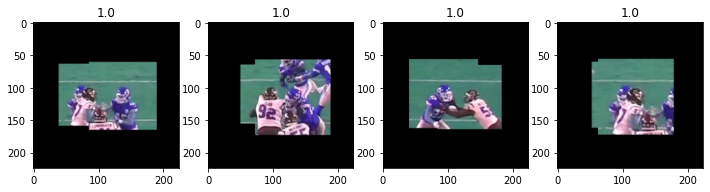

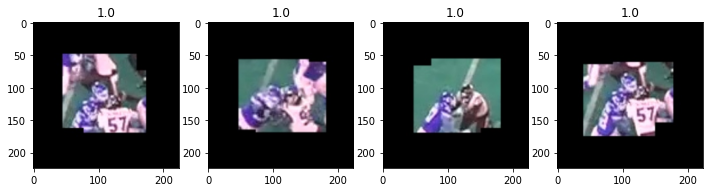

end img is None : 58168_003392_12_38590_47944_Endzone.jpg
side img is None : 58168_003392_12_38590_47944_Sideline.jpg
end img torch.Size([4, 3, 224, 224])
side img torch.Size([4, 3, 224, 224])
features shape = torch.Size([4, 24])
track features shape = torch.Size([4, 4, 12])


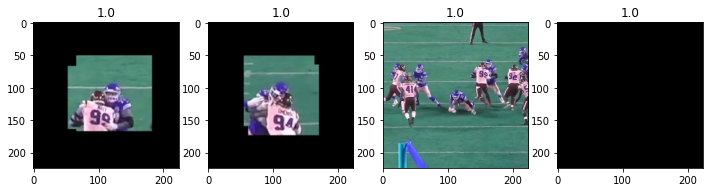

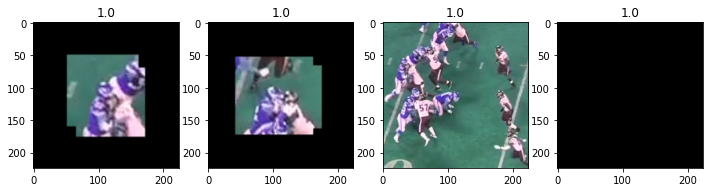

end img torch.Size([4, 3, 224, 224])
side img torch.Size([4, 3, 224, 224])
features shape = torch.Size([4, 24])
track features shape = torch.Size([4, 4, 12])


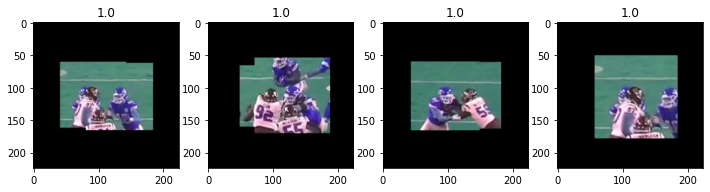

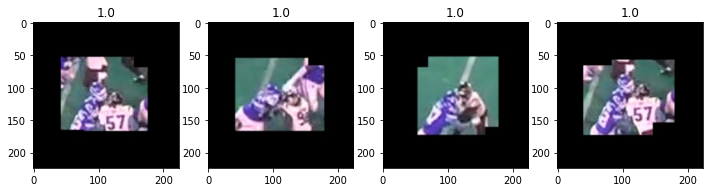

Exception: 

In [77]:
# checkするときは255.で割るのを全体にかける(normalizeがcheckにはないので真っ白とか真っ黒になるのを回避)

show_img_num = 4

pick_df = target_df[target_df["contact"]==1]
train_dataset = NFLDataset(pick_df)

train_loader = DataLoader(
    train_dataset,
    batch_size = show_img_num,
    shuffle = False,
    num_workers = CFG["num_workers"],
    pin_memory = True
)
for batch_idx, (end_img, side_img, features, track_features, targets) in enumerate(train_loader):
    fig = plt.figure(figsize=(12, 25))
    print("end img", end_img.shape)
    print("side img",side_img.shape)
    print("features shape =",features.shape)
    print("track features shape =",track_features.shape)
    for idx in range(show_img_num):
        img = end_img[idx].numpy()
        img = img.transpose((1,2,0))
        fig.add_subplot(1,show_img_num ,idx+1)
        plt.imshow(img)
        plt.title(targets[idx].numpy())
    plt.show()
    
    fig = plt.figure(figsize=(12, 25))
    for idx in range(show_img_num):
        img = side_img[idx].numpy()
        img = img.transpose((1,2,0))
        fig.add_subplot(1,show_img_num ,idx+1)
        plt.imshow(img)
        plt.title(targets[idx].numpy())
    plt.show()
    
    if batch_idx > 10:
        break
del train_loader, train_dataset

raise Exception()


# Model

In [ ]:
# without meta
class NFLNet(nn.Module):
    def __init__(
        self,
        model_name = CFG["model_name"],
        out_features = CFG["num_backbone_features"],
        inp_channels= CFG["inp_channels"],
        pretrained = CFG["pretrained"]
    ):
        super().__init__()
        self.model_end = timm.create_model(model_name, pretrained=pretrained, in_chans=inp_channels, num_classes=out_features)
        self.model_side = timm.create_model(model_name, pretrained=pretrained, in_chans=inp_channels, num_classes=out_features)
        self.mlp = nn.Sequential(
                        nn.Linear(len(CFG["features"]), 32),
                        nn.LayerNorm(32),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                    )
        self.conv1 = nn.Sequential(
                        nn.Conv1d(4, 1, 5),
                        nn.Linear(len(CFG["track_features_y_2"])-4, 32),
                        nn.ReLU(),
                    )
        self.fc = nn.Linear(out_features*2+32+32, 1)
        self.emb_img = nn.Linear(out_features, CFG["num_img_feature"])
        self.emb_track = nn.Linear(32, CFG["num_track_feature"])

    def forward(self, end_img, side_img, features, track_features):
        end_img_feature = self.model_end(end_img)
        side_img_feature = self.model_side(side_img)
        features = self.mlp(features)
        track_features = self.conv1(track_features)
        if features.shape[0] == 1:
            track_features = track_features.reshape(1, -1)
        else:
            track_features = torch.squeeze(track_features)
        # get embeddings
        end_img_embeddings = self.emb_img(end_img_feature)
        side_img_embeddings = self.emb_img(side_img_feature)
        img_embeddings = torch.cat([end_img_embeddings, side_img_embeddings], axis=1)
        track_embeddings = self.emb_track(track_features)
        
        output = self.fc(torch.cat([end_img_feature, side_img_feature, features, track_features], dim=1))
        return output, img_embeddings, track_embeddings

# train fn

In [ ]:
def train_fn(train_loader, model, criterion, epoch ,optimizer, scheduler):
    model.train()
    batch_time = AverageMeter()
    losses = AverageMeter()
    start, end = time.time(), time.time()
    for batch_idx, (images, features, track_features, targets) in enumerate(train_loader):
        images = images.to(device, non_blocking = True).float()
        targets = targets.to(device, non_blocking = True).float().view(-1, 1)      
        features = features.to(device, non_blocking = True).float()
        track_features = track_features.to(device, non_blocking = True).float()
        preds, _, _ = model(images, features, track_features)
        
        loss = criterion(preds, targets)
        losses.update(loss.item(), CFG["batch_size"]) 
        targets = targets.detach().cpu().numpy().ravel().tolist()
        preds = torch.sigmoid(preds).detach().cpu().numpy().ravel().tolist()

        loss.backward() # パラメータの勾配を計算
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
                
        batch_time.update(time.time() - end)
        end = time.time()
        if batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(train_loader)-1):
            print('\t Epoch: [{0}][{1}/{2}] '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                        epoch, batch_idx, len(train_loader), batch_time=batch_time, loss=losses,
                        remain=timeSince(start, float(batch_idx+1)/len(train_loader)),
            ))
        del preds, images, features, targets
    gc.collect()
    torch.cuda.empty_cache()
    return losses.avg

# valid fn

In [ ]:
def valid_fn(model, valid_loader, criterion):
    model.eval()# モデルを検証モードに設定
    test_targets = []
    test_preds = []

    batch_time = AverageMeter()
    losses = AverageMeter()
    start, end = time.time(), time.time()
    for batch_idx, (images, features, track_features, targets) in enumerate(valid_loader):
        images = images.to(device, non_blocking = True).float()
        targets = targets.to(device, non_blocking = True).float().view(-1, 1)
        features = features.to(device, non_blocking = True).float()
        track_features = track_features.to(device, non_blocking = True).float()
        with torch.no_grad():
            preds, _ = model(images, features, track_features)
            loss = criterion(preds, targets)
        losses.update(loss.item(), CFG["batch_size"])
        batch_time.update(time.time() - end)

        targets = targets.detach().cpu().numpy().ravel().tolist()
        preds = torch.sigmoid(preds).detach().cpu().numpy().ravel().tolist()

        test_preds.extend(preds)
        test_targets.extend(targets)
        # score = matthews_corrcoef(preds, targets)
        if batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(valid_loader)-1):
            print('\t EVAL: [{0}/{1}] '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                    batch_idx, len(valid_loader), batch_time=batch_time, loss=losses,
                    remain=timeSince(start, float(batch_idx+1)/len(valid_loader)),
                ))
        del preds, images, features, targets
        gc.collect()
        torch.cuda.empty_cache()
    test_preds = np.array(test_preds)
    test_targets = np.array(test_targets)
    return test_targets, test_preds, losses.avg

# Train loop

In [ ]:
def training_loop(target_df):
    # set model & learning fn
    model = NFLNet()
    model = model.to(device)
    if CFG["kaggle"]:
        wandb.watch(model)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"], amsgrad=False)
    scheduler = CosineAnnealingLR(optimizer, T_max=CFG["T_max"], eta_min=CFG["min_lr"], last_epoch=-1)

    oof_df = pd.DataFrame()
    fold = 0
    # separate train/valid data 
    train_df = target_df[target_df["game_play"].isin(train_game_plays)]
    valid_df = target_df[target_df["game_play"].isin(valid_game_plays)]
    train_dataset = NFLDataset(train_df, train_transform)
    valid_dataset = NFLDataset(valid_df, valid_transform)
    train_loader = DataLoader(train_dataset,batch_size=CFG["batch_size"], shuffle = True,
                                num_workers = CFG["num_workers"], pin_memory = True)
    valid_loader = DataLoader(valid_dataset,batch_size=CFG["batch_size"], shuffle = False,
                                num_workers = CFG["num_workers"], pin_memory = True)

    # training
    best_score = -np.inf
    best_auc = -np.inf
    start_time, end = time.time(), time.time()
    for epoch in range(1, CFG["n_epoch"] + 1):
        print(f'\t === epoch: {epoch}: training ===')
        train_loss_avg = train_fn(train_loader, model, criterion, epoch ,optimizer, scheduler)
        valid_targets, valid_preds, valid_loss_avg = valid_fn(model, valid_loader, criterion)

        valid_score = -np.inf
        valid_threshold = 0
        tn_best, fp_best, fn_best, tp_best = 0, 0, 0, 0
        for idx in range(1, 10, 1):
            thr = idx*0.1
            valid_targets = (np.array(valid_targets) > thr).astype(np.int32)
            valid_binary_preds = (np.array(valid_preds) > thr).astype(np.int32)
            score_tmp = matthews_corrcoef(valid_targets, valid_binary_preds)
            cm = confusion_matrix(valid_targets, valid_binary_preds)
            tn, fp, fn, tp = cm.flatten()
            if score_tmp > valid_score:
                valid_score = score_tmp 
                valid_threshold = thr
                tn_best, fp_best, fn_best, tp_best = tn, fp, fn, tp
        elapsed = time.time() - start_time
        print(f'\t epoch:{epoch}, avg train loss:{train_loss_avg:.4f}, avg valid loss:{valid_loss_avg:.4f}, score:{valid_score:.4f}(th={valid_threshold}) ::: time:{elapsed:.2f}s')
        scheduler.step()
        # validationスコアがbestを更新したらモデルを保存する
        if valid_score > best_score:
            best_score = valid_score
            model_name = CFG["model_name"]
            torch.save(model.state_dict(), f'{CFG["MODEL_DIR"]}/{model_name}_fold{fold}.pth')
            print(f'\t Epoch {epoch} - Save Best Score: {best_score:.4f}. Model is saved.')
            contact_id = valid_df["contact_id"].values
            _oof_df = pd.DataFrame({
                "contact_id" : contact_id,
                "pred" : valid_preds,
                "contact" : valid_targets,
                "fold" : fold,
            })
            
        auc_score = roc_auc_score(valid_targets, valid_preds)
        if best_auc < auc_score:
            best_auc = auc_score
            model_name = CFG["model_name"]
            torch.save(model.state_dict(), f'{CFG["MODEL_DIR"]}/{model_name}_bestauc_fold{fold}.pth')
            print(f'\t Epoch {epoch} - Save Best AUC Score: {best_auc:.4f}. Model is saved.')
            
        logging_metrics_epoch(fold, epoch, train_loss_avg, valid_loss_avg, valid_score, valid_threshold, tn_best, fp_best, fn_best, tp_best, auc_score)

    del train_loader, train_dataset, valid_loader, valid_dataset
    oof_df = pd.concat([oof_df, _oof_df], axis = 0)
    del _oof_df
    gc.collect()
    torch.cuda.empty_cache()
    return oof_df

In [ ]:
if CFG["kaggle"]:
    oof_df = training_loop(target_df)
    wandb.finish()
else:
    with mlflow.start_run(experiment_id=experiment_id, run_name=CFG["EXP_NAME"]) as run:
        mlflow.log_dict(CFG, "configuration.yaml")
        mlflow.log_param("positive data num", len(target_df[target_df["contact"]==1]))
        mlflow.log_param("negative data num", len(target_df[target_df["contact"]==0]))
        oof_df = training_loop(target_df)

In [ ]:
display(oof_df)
if CFG["kaggle"]:
    oof_filename = os.path.join(CFG["OUTPUT_DIR"], "oof_df.csv")
    oof_df.to_csv(oof_filename, index=False)
else:
    oof_filename = os.path.join(CFG["OUTPUT_DIR"], CFG["EXP_NAME"], "oof_df.csv")
    oof_df.to_csv(oof_filename, index=False)

# Create CNN-Emb df

In [ ]:
target_df = pd.read_csv(CFG["TARGET_CSV"])
target_game_plays = target_df["game_play"].unique()[-100:]
CFG["target_game_plays"] = list(target_game_plays)
target_df = target_df[target_df["game_play"].isin(target_game_plays)]

if CFG["DEBUG"]:
    target_df = target_df.sample(CFG["sample_num"])
elif CFG["sample_num"] != -1:
    target_df = target_df.sample(CFG["sample_num"])

target_df = target_df.reset_index(drop=True)
target_df["is_ground"] = (target_df["nfl_player_id_2"] == "G").astype(np.int)
target_df["is_helmet"] = 1 - ((target_df["E_width_1"]==0) & (target_df["E_width_2"]==0) & (target_df["S_width_1"]==0) & (target_df["S_width_2"]==0)).astype(np.int)
print(len(target_df))
display(target_df["contact"].value_counts())

In [ ]:
diff_cols = ['speed', 'distance', 'direction', 'orientation','acceleration', 'sa']

for col in diff_cols:
    target_df[f"{col}_diff"] = abs(target_df[f"{col}_1"] - target_df[f"{col}_2"])

In [ ]:
emb_dataset = NFLDataset(target_df, valid_transform)
emb_loader = DataLoader(
    emb_dataset,
    batch_size = CFG["batch_size"],
    shuffle = False,
    num_workers = CFG["num_workers"],
    pin_memory = True
)
model = NFLNet()
model = model.to(device)
# model.load_state_dict(torch.load(CFG["trained_model_path"]))
model.load_state_dict(torch.load(f'{CFG["MODEL_DIR"]}/{CFG["model_name"]}_fold0.pth'))
model.eval()# モデルを検証モードに設定
cnn_features = []
preds_list = []
for batch_idx, (images, features, track_features, targets) in enumerate(emb_loader):
    print("\r {}/{}".format(batch_idx, len(emb_loader)), end="")
    images = images.to(device, non_blocking = True).float()
    features = features.to(device, non_blocking = True).float()
    track_features = track_features.to(device, non_blocking = True).float()    
    preds, emb = model(images, features, track_features)    
    emb_numpy = emb.detach().cpu().numpy()
    preds = torch.sigmoid(preds).detach().cpu().numpy().ravel().tolist()
    cnn_features.extend(emb_numpy)
    preds_list.extend(preds)

In [ ]:
cnn_feature_df = pd.DataFrame(cnn_features, columns=[f'cnn_feature_{i}' for i in range(CFG["num_extractFTR"])])
# display(cnn_feature_df)

feat_num = CFG["num_extractFTR"]
preds_list_numpy = np.array(preds_list)
preds_list_numpy = preds_list_numpy.reshape(len(preds_list_numpy))
cnn_feature_df[f"cnn_feature_{feat_num}"] = preds_list_numpy
display(cnn_feature_df)

In [ ]:
concat_df = target_df.copy()
concat_df = pd.concat([target_df["contact_id"], cnn_feature_df], axis=1)
display(concat_df)
exp_name = CFG["EXP_NAME"]
cnn_features_filename = os.path.join(CFG["OUTPUT_DIR"], CFG["EXP_NAME"] ,f"{exp_name}_emb.csv")
concat_df.to_csv(cnn_features_filename, index=False)